In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [2]:
#import data
df = pd.read_csv('app.csv')

In [3]:
df.head()

,record,date,ssn,firstname,lastname,address,zip5,dob,homephone,fraud_label
0,1,20160101,379070012,XRRAMMTR,SMJETJMJ,6861 EUTST PL,2765,19070626,1797504115,0
1,2,20160101,387482503,MAMSTUJR,RTTEMRRR,7280 URASA PL,57169,19340615,4164239415,1
2,3,20160101,200332444,SZMMUJEZS,EUSEZRAE,5581 RSREX LN,56721,19070626,216537580,0
3,4,20160101,747451317,SJJZSXRSZ,ETJXTXXS,1387 UJZXJ RD,35286,19440430,132144161,0
4,5,20160101,24065868,SSSXUEJMS,SSUUJXUZ,279 EAASA WY,3173,19980315,6101082272,0


### Fix Frivolous Values and Clean Data

In [4]:
#datatype
df['date'] = pd.to_datetime(df.date.astype(str).apply(lambda x: x[:4] + '-' + x[4:6] + '-' + x[6:]))
df['zip5'].apply(lambda x: '{0:0>5}'.format(x))

#frivolous values

#ssn
df.loc[df.ssn==999999999, 'ssn'] = -df[df.ssn==999999999]['record']
df['ssn'] = df['ssn'].apply(lambda x: '{0:0>9}'.format(x))

#address
df.loc[df.address== '123 MAIN ST', 'address'] = \
    df.loc[df.address== '123 MAIN ST', 'address'].apply(lambda x: str(x) + ' RECORD')

#dob
df.loc[df.dob==19070626, 'dob'] = -df[df.dob==19070626]['record']
df['dob'] = df['dob'].apply(lambda x: '{0:0>8}'.format(x))

#homephone
df.loc[df.homephone==9999999999, 'homephone'] = -df[df.homephone==9999999999]['record']
df['homephone'] = df['homephone'].apply(lambda x: '{0:0>10}'.format(x))

In [5]:
df['zip5'] = df['zip5'].apply(str)

### Create Entities

In [6]:
df['name'] = df.firstname + df.lastname
df['fulladdress'] = df.address + df.zip5
df['name_dob'] = df.name + df.dob
df['name_fulladdress'] = df.name + df.fulladdress
df['name_homephone'] = df.name + df.homephone
df['fulladdress_dob'] = df.fulladdress + df.dob
df['fulladdress_homephone'] = df.fulladdress + df.homephone
df['dob_homephone'] = df.dob + df.homephone
df['homephone_name_dob'] = df.homephone + df.name_dob

In [7]:
#create a bunch more columns for pairings of other columns and ssn
for field in list(df.iloc[:, np.r_[3:9, 12:15]].columns):
    df['ssn_' + field] = df.ssn + df[field]

In [8]:
attributes = list(df.iloc[:, np.r_[2,5,6,7,8,10,11,12:28]].columns)
attributes

['ssn',
 'address',
 'zip5',
 'dob',
 'homephone',
 'name',
 'fulladdress',
 'name_dob',
 'name_fulladdress',
 'name_homephone',
 'fulladdress_dob',
 'fulladdress_homephone',
 'dob_homephone',
 'homephone_name_dob',
 'ssn_firstname',
 'ssn_lastname',
 'ssn_address',
 'ssn_zip5',
 'ssn_dob',
 'ssn_homephone',
 'ssn_name_dob',
 'ssn_name_fulladdress',
 'ssn_name_homephone']

### Risk Table for Day of Week

In [9]:
import calendar
df['dow'] = df.date.apply(lambda x: calendar.day_name[x.weekday()])

In [10]:
train_test = df[df.date < '2016-11-01']

In [11]:
#do statistical smoothing
c = 4; nmid=20; y_avg = train_test['fraud_label'].mean()
y_dow = train_test.groupby('dow')['fraud_label'].mean()
num = train_test.groupby('dow').size()
y_dow_smooth = y_avg + (y_dow - y_avg)/(1+ np.exp(-(num-nmid)/c))
df['dow_risk'] = df.dow.map(y_dow_smooth)

## Create Variables

### Velocity + Day Since

In [12]:
df1 = df.copy()
final = df.copy()
df1['check_date'] = df1.date
df1['check_record'] = df1.record

In [13]:
import datetime as dt
#start = timer()
for entity in attributes:
    #st = timer()
    df_1 = df1[['record', 'date', entity]]
    df_r = df1[['check_record', 'check_date', entity]]
    temp = pd.merge(df_1, df_r, left_on = entity, right_on = entity)
    
    #days since
    day_since_df = temp[temp.record > temp.check_record][['record', 'date', 'check_date']] \
    .groupby('record')[['date', 'check_date']].last()
    mapper = (day_since_df.date - day_since_df.check_date).dt.days
    final[entity + '_day_since'] = final.record.map(mapper)
    final[entity + '_day_since'].fillna(365, inplace = True)
    print(f'\n{entity}_day_since -----> Done')
    
    #velocity
    for offset_t in [0,1,3,7,14,30]:
        count_day_df = temp[(temp.check_date >= (temp.date - dt.timedelta(offset_t)))
                           & (temp.record >= temp.check_record)]
        col_name = f'{entity}_count_{offset_t}'
        mapper2 = count_day_df.groupby('record')[entity].count()
        final[col_name] = final.record.map(mapper2)
        
        print(f'{entity}_count_{str(offset_t)}-----> Done')
        
    #print(f' Run time for entity {entity} ------------ {timer() - st:0.2f}s')
    
#print(f'Total run time: {(timer() - start) / 60:0.2f}min')


ssn_day_since -----> Done
ssn_count_0-----> Done
ssn_count_1-----> Done
ssn_count_3-----> Done
ssn_count_7-----> Done
ssn_count_14-----> Done
ssn_count_30-----> Done

address_day_since -----> Done
address_count_0-----> Done
address_count_1-----> Done
address_count_3-----> Done
address_count_7-----> Done
address_count_14-----> Done
address_count_30-----> Done

zip5_day_since -----> Done
zip5_count_0-----> Done
zip5_count_1-----> Done
zip5_count_3-----> Done
zip5_count_7-----> Done
zip5_count_14-----> Done
zip5_count_30-----> Done

dob_day_since -----> Done
dob_count_0-----> Done
dob_count_1-----> Done
dob_count_3-----> Done
dob_count_7-----> Done
dob_count_14-----> Done
dob_count_30-----> Done

homephone_day_since -----> Done
homephone_count_0-----> Done
homephone_count_1-----> Done
homephone_count_3-----> Done
homephone_count_7-----> Done
homephone_count_14-----> Done
homephone_count_30-----> Done

name_day_since -----> Done
name_count_0-----> Done
name_count_1-----> Done
name_count_3

### Relative Velocity

In [14]:
for att in attributes: 
    for d in ['0','1']:
        for dd in ['3','7','14','30']:
            final[att + '_count_' + d + '_by_' + dd]\
            = final[att + '_count_' + d] /  (final[att + '_count_' + dd] / float(dd))

In [15]:
final.head()

,record,date,ssn,firstname,lastname,address,zip5,dob,homephone,fraud_label,...,ssn_name_fulladdress_count_1_by_14,ssn_name_fulladdress_count_1_by_30,ssn_name_homephone_count_0_by_3,ssn_name_homephone_count_0_by_7,ssn_name_homephone_count_0_by_14,ssn_name_homephone_count_0_by_30,ssn_name_homephone_count_1_by_3,ssn_name_homephone_count_1_by_7,ssn_name_homephone_count_1_by_14,ssn_name_homephone_count_1_by_30
0,1,2016-01-01,379070012,XRRAMMTR,SMJETJMJ,6861 EUTST PL,2765,000000-1,1797504115,0,...,14.0,30.0,3.0,7.0,14.0,30.0,3.0,7.0,14.0,30.0
1,2,2016-01-01,387482503,MAMSTUJR,RTTEMRRR,7280 URASA PL,57169,19340615,4164239415,1,...,14.0,30.0,3.0,7.0,14.0,30.0,3.0,7.0,14.0,30.0
2,3,2016-01-01,200332444,SZMMUJEZS,EUSEZRAE,5581 RSREX LN,56721,000000-3,0216537580,0,...,14.0,30.0,3.0,7.0,14.0,30.0,3.0,7.0,14.0,30.0
3,4,2016-01-01,747451317,SJJZSXRSZ,ETJXTXXS,1387 UJZXJ RD,35286,19440430,0132144161,0,...,14.0,30.0,3.0,7.0,14.0,30.0,3.0,7.0,14.0,30.0
4,5,2016-01-01,024065868,SSSXUEJMS,SSUUJXUZ,279 EAASA WY,3173,19980315,6101082272,0,...,14.0,30.0,3.0,7.0,14.0,30.0,3.0,7.0,14.0,30.0


Let's now take our featured variables and prep them for feature selection. We'll only use the train/test data (not the out of time data) and we'll take out the first few weeks of data since the variables might not be fully formed at the very beginning of the year. 

In [16]:
#calculate fraud label variable and random variable. We need to use a different name for the fraud label to get it to work. 
final['fraud_label_tester'] = final['fraud_label']
final['random_variable'] = np.random.uniform(0, 1, size = final.shape[0])

In [17]:
feature_selection_df = final[final['date'] > '2016-01-21']

In [18]:
fsdf = feature_selection_df[feature_selection_df['date'] < '2016-11-01']

Now we're ready to do some initial filtering. 

In [19]:
#Calculate univariate KS score
goods = fsdf[fsdf['fraud_label'] == 0]
bads = fsdf[fsdf['fraud_label'] == 1]

import scipy.stats as sps

KSFDR = pd.DataFrame(columns = ['VarName', 'KS', 'FDR', 'rank_KS', 'rank_FDR', 'avg_rank'])
i = 0
for column in fsdf:
    if column != 'fraud_label':
        KSFDR.loc[i, 'KS'] = sps.ks_2samp(goods[column],bads[column])[0]
        KSFDR.loc[i, 'VarName'] = column
        i += 1

In [20]:
#calculate a univariate FDR at 3%
numbads = sum(fsdf['fraud_label'])
j = 0
topRows = int(round(len(fsdf)*0.03))
for column in fsdf: 
    if column != 'fraud_label':
        temp = fsdf[[column,'fraud_label']].copy()
        temp0 = temp.sort_values(column,ascending=False)
        temp1 = temp0.head(topRows)
        temp2 = temp0.tail(topRows)
        needed1 = temp1.loc[:,'fraud_label']
        needed2 = temp2.loc[:,'fraud_label']
        FDR1 = sum(needed1)/numbads
        FDR2 = sum(needed2)/numbads               
        FDRate = np.maximum(FDR1,FDR2)
        KSFDR.loc[j, 'FDR'] = FDRate
        j = j + 1

In [21]:
KSFDR

,VarName,KS,FDR,rank_KS,rank_FDR,avg_rank
0,record,0.0266067,0.035247,NaN,NaN,NaN
1,date,0.0265581,0.035336,NaN,NaN,NaN
2,ssn,0.0171297,0.0282154,NaN,NaN,NaN
3,firstname,0.0146215,0.035158,NaN,NaN,NaN
4,lastname,0.00953977,0.0303516,NaN,NaN,NaN
...,...,...,...,...,...,...
371,ssn_name_homephone_count_1_by_7,0.0255015,0.0555407,NaN,NaN,NaN
372,ssn_name_homephone_count_1_by_14,0.0448645,0.0738763,NaN,NaN,NaN
373,ssn_name_homephone_count_1_by_30,0.0608695,0.0847352,NaN,NaN,NaN
374,fraud_label_tester,1,1,NaN,NaN,NaN


In [22]:
#rank
KSFDR['rank_KS'] = KSFDR['KS'].rank(ascending = True)
KSFDR['rank_FDR'] = KSFDR['FDR'].rank(ascending = True)

#average rank sort
KSFDR['avg_rank'] = (KSFDR['rank_KS'] + KSFDR['rank_FDR']) / 2
KSFDR.sort_values(by=['avg_rank'], ascending=False, inplace=True)


In [23]:
ksfdr_out = KSFDR.iloc[:,:3]
ksfdr_out.to_csv('ksfdr.csv')

In [24]:
ksfdr_out

,VarName,KS,FDR
374,fraud_label_tester,1,1
71,fulladdress_day_since,0.335188,0.359324
36,address_day_since,0.335744,0.355674
42,address_count_30,0.334329,0.35603
77,fulladdress_count_30,0.333973,0.357276
...,...,...,...
100,fulladdress_dob_count_0,0.00185768,0.034802
163,ssn_homephone_count_0,0.00183675,0.034802
93,name_homephone_count_0,0.00182629,0.034802
177,ssn_name_fulladdress_count_0,0.00181844,0.034802


In [25]:
KSFDR['avg_rank'] = KSFDR['avg_rank'].astype('int')

In [26]:
KSFDR['avg_rank'] = KSFDR['avg_rank'].astype('str')

In [27]:
KSFDR['KS'] = KSFDR['KS'].astype('float')

In [28]:
KSFDR['FDR'] = KSFDR['FDR'].astype('float')

<AxesSubplot:xlabel='avg_rank', ylabel='KS'>

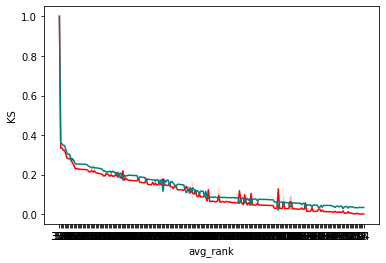

In [29]:
import seaborn as sns 
sns.lineplot(data = KSFDR, x = 'avg_rank', y = 'KS', color = 'red')
sns.lineplot(data = KSFDR, x = 'avg_rank', y = 'FDR', color = 'teal')

In [30]:
filtered = KSFDR.iloc[1:81, :]

In [31]:
filtered.shape

(80, 6)

In [32]:
filtered.head()

,VarName,KS,FDR,rank_KS,rank_FDR,avg_rank
71,fulladdress_day_since,0.335188,0.359324,374.0,375.0,374
36,address_day_since,0.335744,0.355674,375.0,372.0,373
42,address_count_30,0.334329,0.356030,373.0,373.0,373
77,fulladdress_count_30,0.333973,0.357276,372.0,374.0,373
41,address_count_14,0.323754,0.348198,371.0,371.0,371


In [33]:
topVarNames = list(filtered['VarName'])

In [34]:
topVars_df = fsdf[topVarNames]       
topVars_df['fraud_label'] = fsdf['fraud_label']

<ipython-input-34-27b4b37a865a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  topVars_df['fraud_label'] = fsdf['fraud_label']


Now that we have a dataframe with our KSFDR average rank, we can take a certain number of variables off the top and run them through a logistic regression wrapper. 

In [39]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFECV
model = LogisticRegression(penalty='l2', class_weight='balanced', max_iter = 600)
rfecv = RFECV(estimator=model, step=1, cv=2, verbose=2, n_jobs=1, scoring="roc_auc")
X = topVars_df.drop('fraud_label', axis = 1)
y = topVars_df['fraud_label']
rfecv.fit(X, y)

MemoryError: Unable to allocate 254. MiB for an array with shape (43, 775724) and data type int64

In [36]:
#sorted variable dataframe

var_selected = pd.DataFrame(sorted(zip(map(lambda x: round(x), rfecv.ranking_), data.columns)),
                            columns = ['ranking', 'variable'])
print(var_selected)


AttributeError: 'RFECV' object has no attribute 'ranking_'

AttributeError: 'RFECV' object has no attribute 'grid_scores_'

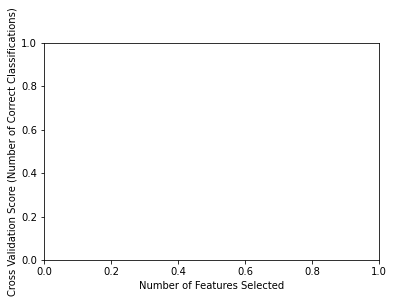

In [37]:
#plot
plt.figure()
plt.xlabel('Number of Features Selected')
plt.ylabel('Cross Validation Score (Number of Correct Classifications)')
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()